In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [68]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')
df_subm = pd.read_csv('dataset/sample_submission.csv')

df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

In [69]:
df_train.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


# 기본 정보 확인

In [70]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   carat    193573 non-null  float64
 1   cut      193573 non-null  object 
 2   color    193573 non-null  object 
 3   clarity  193573 non-null  object 
 4   depth    193573 non-null  float64
 5   table    193573 non-null  float64
 6   x        193573 non-null  float64
 7   y        193573 non-null  float64
 8   z        193573 non-null  float64
 9   price    193573 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 14.8+ MB


### null값 
- 없음

In [71]:
df_train.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [31]:
df_test.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

### feature 값 확인
- feature 도메인 지식
- 몇개의 unique 값이 있는지, 이상한 값이 존재하는지

**carat**  
weight

**cut**  
- Ideal
- Premium
- Very Good
- Good
- Fair
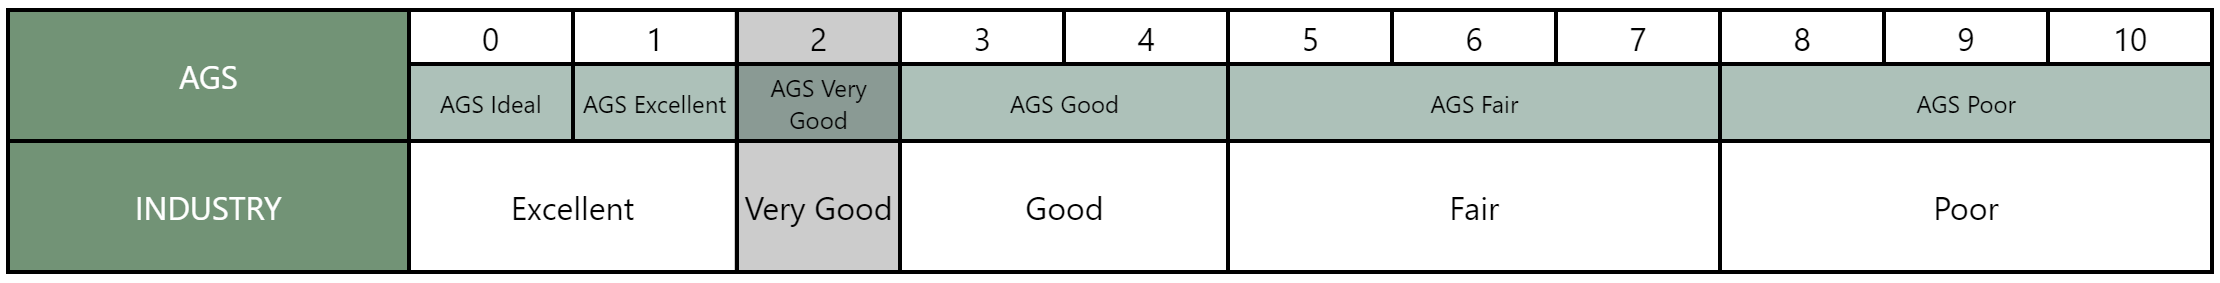

In [47]:
print('# cut')
print('>train')
print(df_train.cut.value_counts())
print('>test')
print(df_test.cut.value_counts())

# cut
>train
Ideal        92454
Premium      49910
Very Good    37566
Good         11622
Fair          2021
Name: cut, dtype: int64
>test
Ideal        61223
Premium      33498
Very Good    25468
Good          7554
Fair          1307
Name: cut, dtype: int64


color  
- D
- E
- F
- G
- H
- I
- J
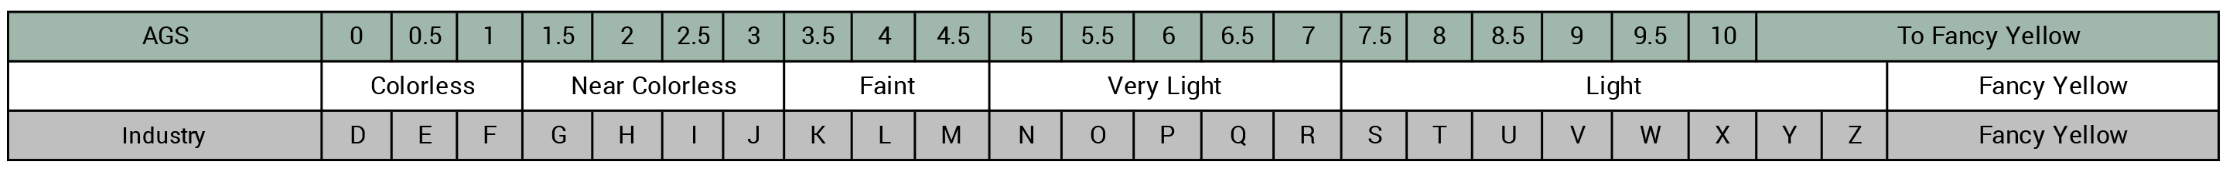

In [46]:
print('# color')
print('>train')
print(df_train.color.value_counts())
print('>test')
print(df_test.color.value_counts())

# color
>train
G    44391
E    35869
F    34258
H    30799
D    24286
I    17514
J     6456
Name: color, dtype: int64
>test
G    29561
E    24086
F    22767
H    20576
D    16167
I    11685
J     4208
Name: color, dtype: int64


clarity  
**Usually, gems with greater clarity are considered more valuable** than gems of the same species with lower clarity, all other properties being equal. For some gems, like rubies, the difference can be significant. For other gems, the difference may be minimal.  
However, **just because a gem has a type II or III clarity grade doesn't automatically mean its value is lower than a type I gem of the same clarity grade.** For example, the prices of emeralds (type III) and sapphires (type II) can greatly exceed those of most type I gems.
- IF
- VVS: very, very small inclusions
- VS: very small inclusions
- SI1 and SI2: small inclusions
- I1, I2, and I3: included
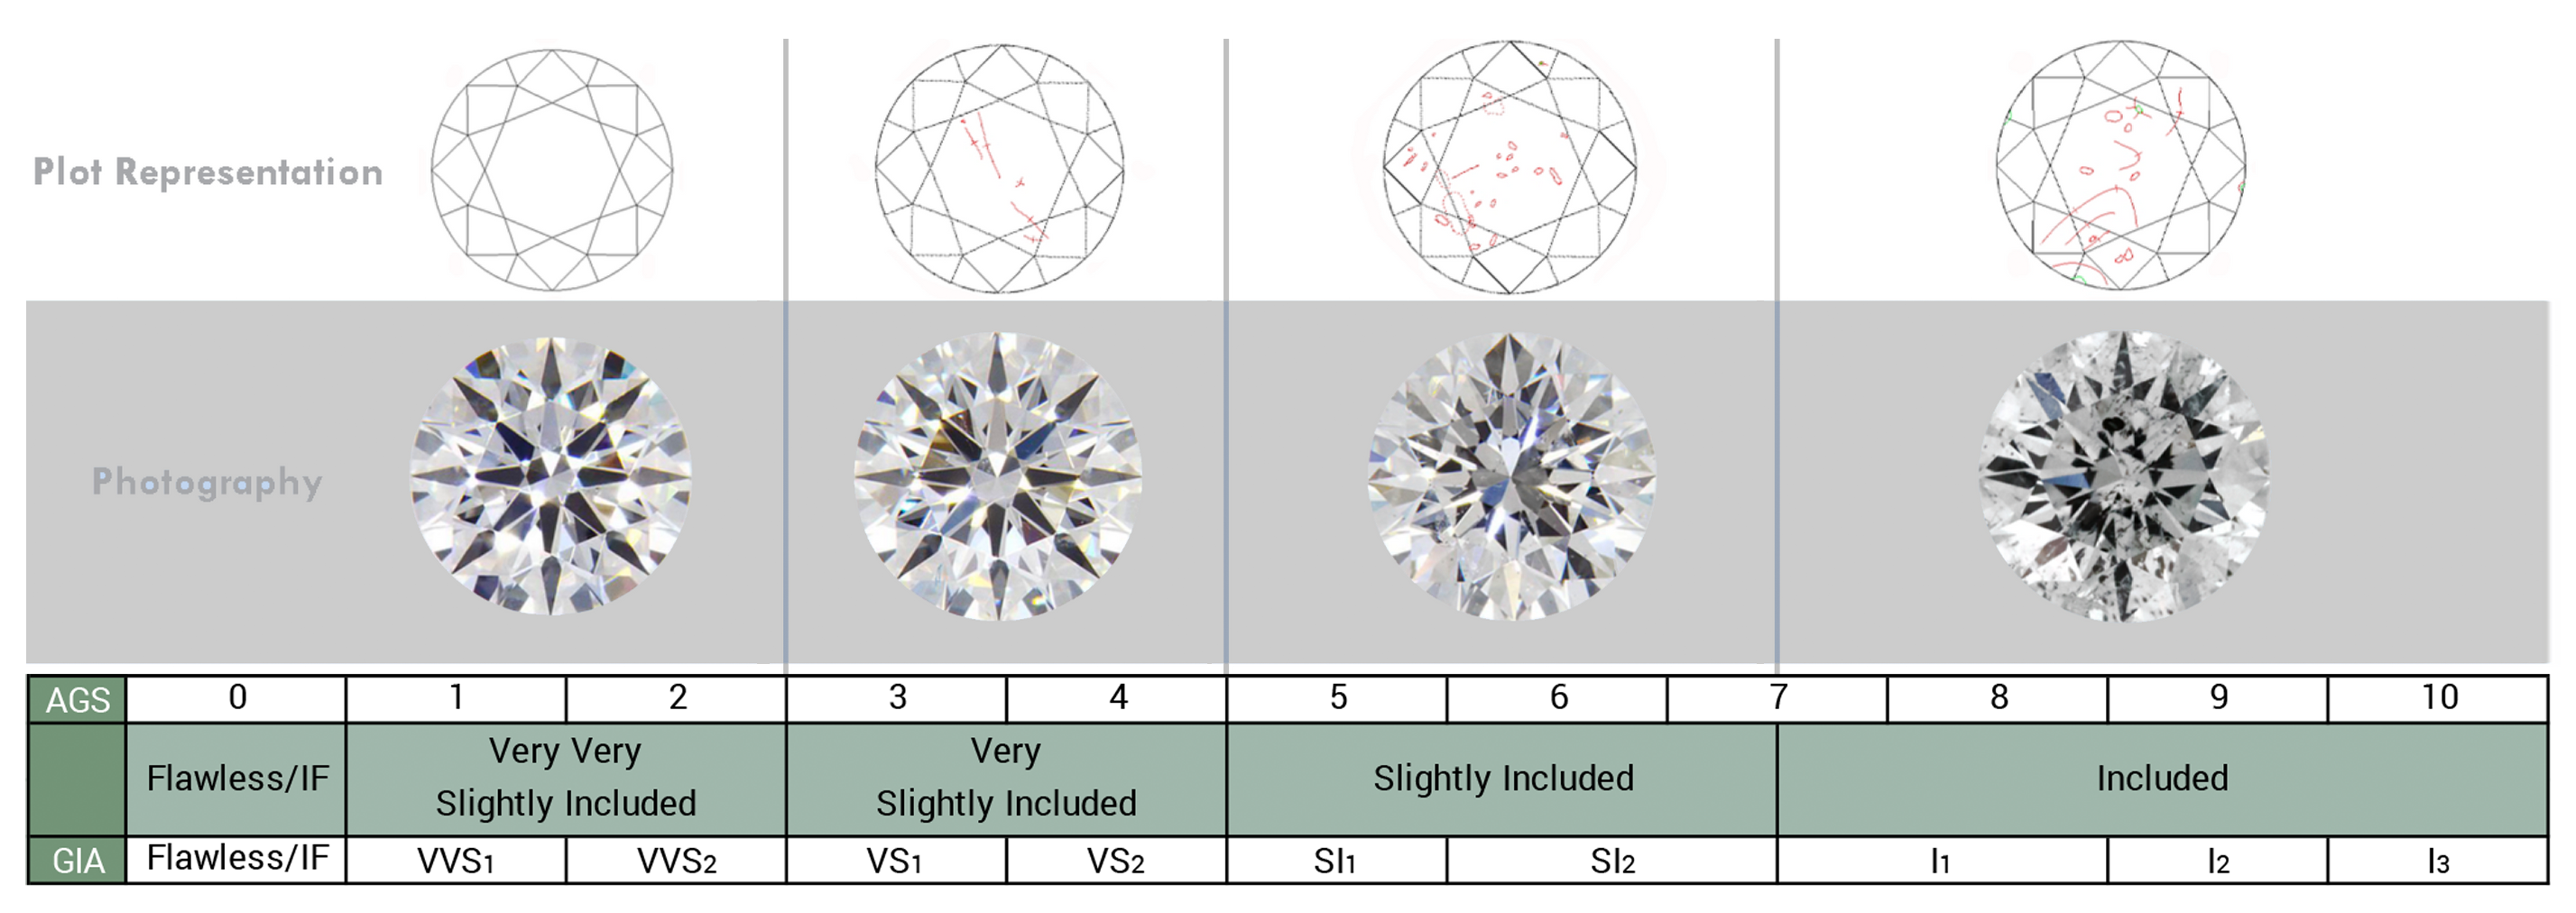

In [45]:
print('# clarity')
print('>train')
print(df_train.clarity.value_counts())
print('>test')
print(df_test.clarity.value_counts())

# clarity
>train
SI1     53272
VS2     48027
VS1     30669
SI2     30484
VVS2    15762
VVS1    10628
IF       4219
I1        512
Name: clarity, dtype: int64
>test
SI1     35336
VS2     32201
VS1     20519
SI2     20167
VVS2    10317
VVS1     7327
IF       2791
I1        392
Name: clarity, dtype: int64


**depth**  
height, divided by its average diemeter

**table**
width, divided by its average diameter

# Baseline model 성능

In [54]:
model = RandomForestRegressor()
cv = StratifiedKFold(n_splits=5)

X, y = df_train.iloc[:,:-1], df_train['price']

scores = []
for train_index, val_index in cv.split(X, y):
    X_train, X_val = X.iloc[train_index, :], X.iloc[val_index, :]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model.fit(X_train, y_train)
    score = mean_squared_error(y_val, model.predict(X_val))
    scores.append(score)
    print(score)

print('mse', np.mean(scores))

384261.58961206785
374079.554714255
369478.6551390953
364969.4527627005
356859.70198323234
mse 369929.79084227013


In [80]:
X, y = df_train.iloc[:,:-1], df_train['price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
model.fit(X_train, y_train)
score = mean_squared_error(y_val, model.predict(X_val))
print(score)

368198.2532833158


# 시각화

<AxesSubplot:xlabel='price', ylabel='Density'>

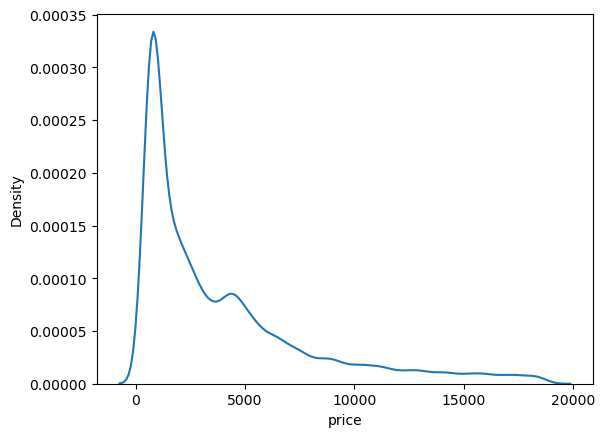

In [50]:
sns.kdeplot(data=df_train, x='price')

<AxesSubplot:xlabel='z', ylabel='Density'>

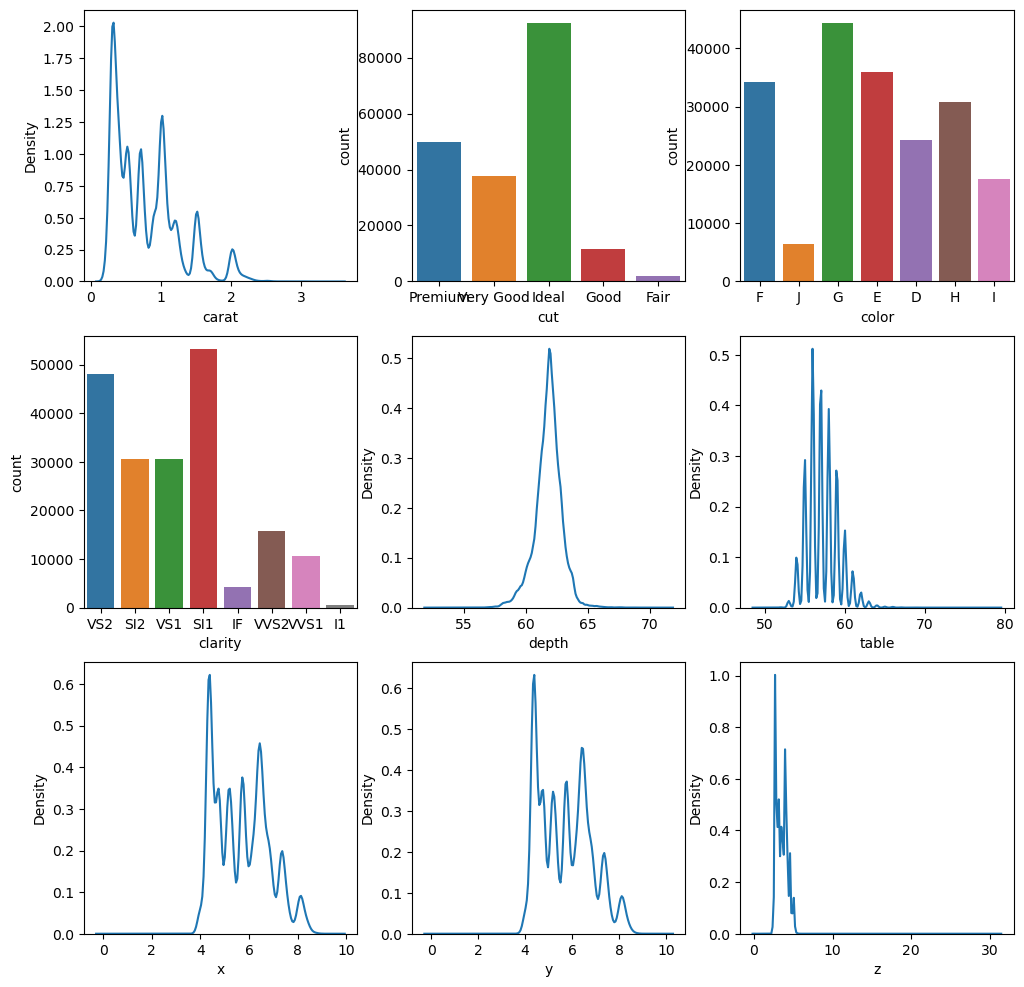

In [43]:
fig, ax = plt.subplots(3,3, figsize=(12,12))

sns.kdeplot(data=df_train, x=df_train.columns[0], ax=ax[0,0])
sns.countplot(data=df_train, x=df_train.columns[1], ax=ax[0,1])
sns.countplot(data=df_train, x=df_train.columns[2], ax=ax[0,2])
sns.countplot(data=df_train, x=df_train.columns[3], ax=ax[1,0])
sns.kdeplot(data=df_train, x=df_train.columns[4], ax=ax[1,1])
sns.kdeplot(data=df_train, x=df_train.columns[5], ax=ax[1,2])
sns.kdeplot(data=df_train, x=df_train.columns[6], ax=ax[2,0])
sns.kdeplot(data=df_train, x=df_train.columns[7], ax=ax[2,1])
sns.kdeplot(data=df_train, x=df_train.columns[8], ax=ax[2,2])

### LabelEncoding

In [72]:
cut_map = {'Fair':0,
           'Good':1,
           'Very Good':2,
           'Premium':3,
           'Ideal':4}
df_train['cut'] = df_train['cut'].map(cut_map)
df_test['cut'] = df_test['cut'].map(cut_map)

color_map = {'D':0, 
             'E':1, 
             'F':2, 
             'G':3, 
             'H':4, 
             'I':5, 
             'J':6}
df_train['color'] = df_train['color'].map(color_map)
df_test['color'] = df_test['color'].map(color_map)

clarity_map = {'IF':0, 
               'VVS1':1, 
               'VVS2':2, 
               'VS1':3, 
               'VS2':4, 
               'SI1':5, 
               'SI2':6, 
               'I1':7, 
               'I2':8, 
               'I3':9}
df_train['clarity'] = df_train['clarity'].map(clarity_map)
df_test['clarity'] = df_test['clarity'].map(clarity_map)

df_train.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.52,3,2,4,62.2,58.0,7.27,7.33,4.55,13619
1,2.03,2,6,6,62.0,58.0,8.06,8.12,5.05,13387
2,0.70,4,3,3,61.2,57.0,5.69,5.73,3.50,2772
3,0.32,4,3,3,61.6,56.0,4.38,4.41,2.71,666
4,1.70,3,3,4,62.6,59.0,7.65,7.61,4.77,14453


<AxesSubplot:xlabel='z', ylabel='Density'>

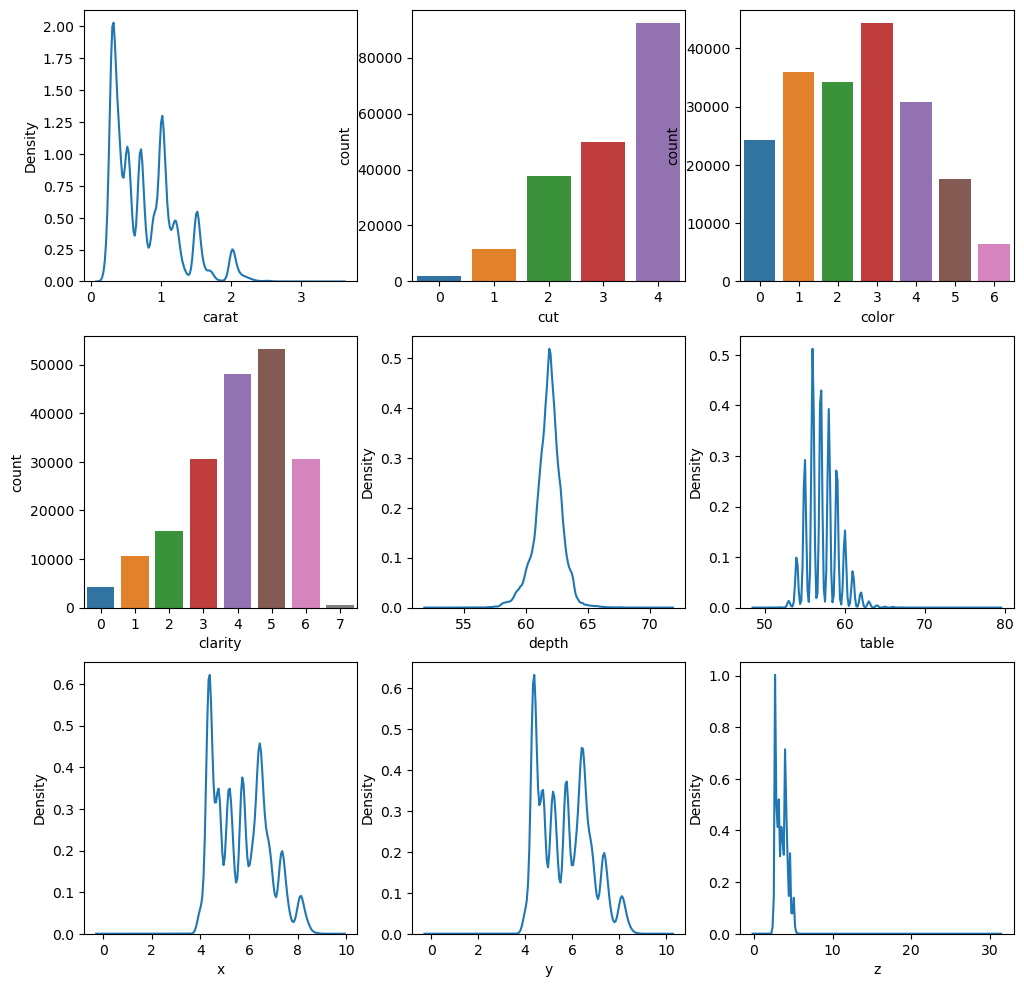

In [49]:
fig, ax = plt.subplots(3,3, figsize=(12,12))

sns.kdeplot(data=df_train, x=df_train.columns[0], ax=ax[0,0])
sns.countplot(data=df_train, x=df_train.columns[1], ax=ax[0,1])
sns.countplot(data=df_train, x=df_train.columns[2], ax=ax[0,2])
sns.countplot(data=df_train, x=df_train.columns[3], ax=ax[1,0])
sns.kdeplot(data=df_train, x=df_train.columns[4], ax=ax[1,1])
sns.kdeplot(data=df_train, x=df_train.columns[5], ax=ax[1,2])
sns.kdeplot(data=df_train, x=df_train.columns[6], ax=ax[2,0])
sns.kdeplot(data=df_train, x=df_train.columns[7], ax=ax[2,1])
sns.kdeplot(data=df_train, x=df_train.columns[8], ax=ax[2,2])

<AxesSubplot:xlabel='z', ylabel='price'>

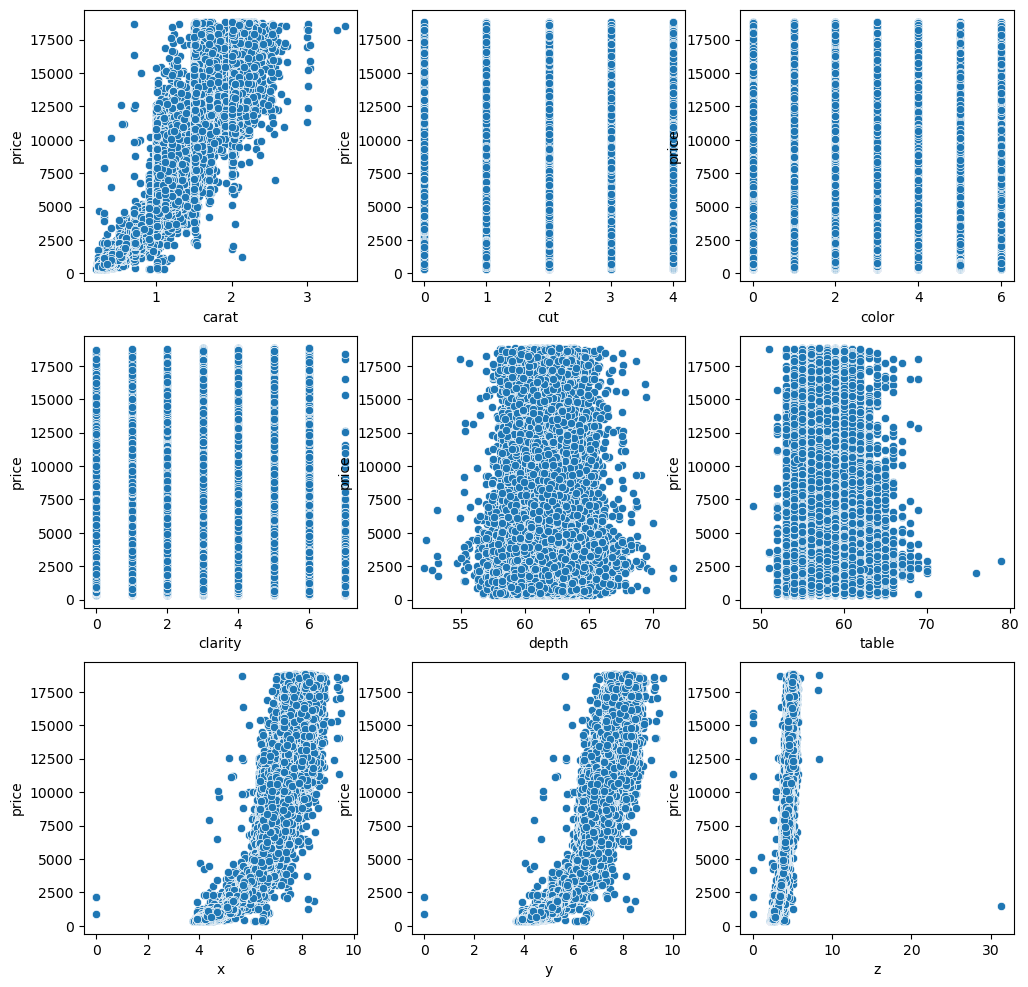

In [51]:
fig, ax = plt.subplots(3,3, figsize=(12,12))

sns.scatterplot(data=df_train, x=df_train.columns[0], y='price', ax=ax[0,0])
sns.scatterplot(data=df_train, x=df_train.columns[1], y='price', ax=ax[0,1])
sns.scatterplot(data=df_train, x=df_train.columns[2], y='price', ax=ax[0,2])
sns.scatterplot(data=df_train, x=df_train.columns[3], y='price', ax=ax[1,0])
sns.scatterplot(data=df_train, x=df_train.columns[4], y='price', ax=ax[1,1])
sns.scatterplot(data=df_train, x=df_train.columns[5], y='price', ax=ax[1,2])
sns.scatterplot(data=df_train, x=df_train.columns[6], y='price', ax=ax[2,0])
sns.scatterplot(data=df_train, x=df_train.columns[7], y='price', ax=ax[2,1])
sns.scatterplot(data=df_train, x=df_train.columns[8], y='price', ax=ax[2,2])

### correlation

<AxesSubplot:>

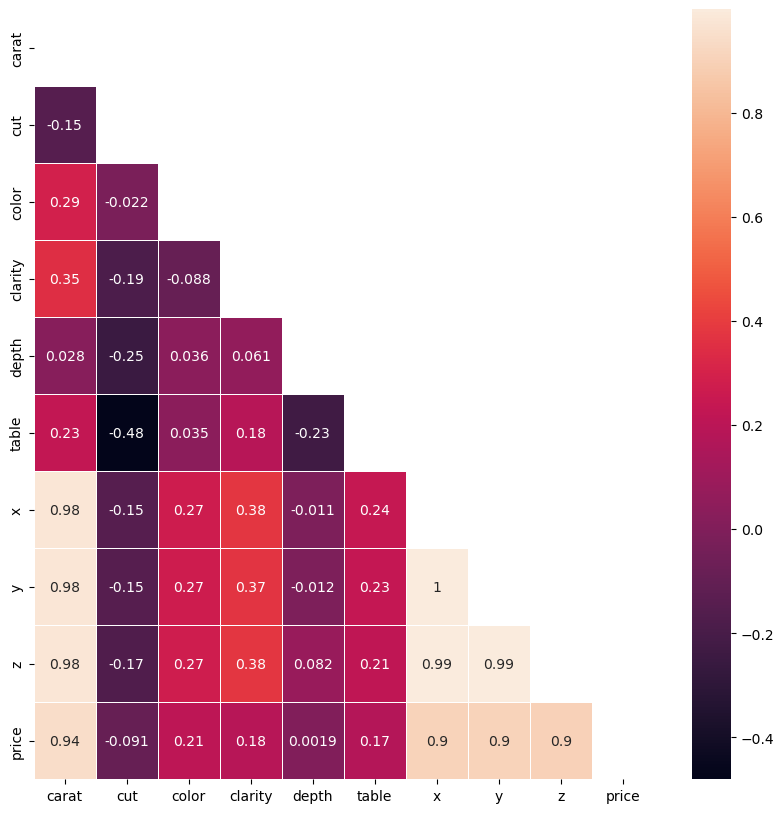

In [78]:
plt.figure(figsize=(10,10))
corr = df_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, linewidths=.5, annot=True)

### x, y, z

In [56]:
df_train[df_train['x']==0]

,carat,cut,color,clarity,depth,table,x,y,z,price
92703,0.71,1,2,5,64.1,60.0,0.0,0.00,0.0,2130
170318,0.71,1,0,4,64.1,60.0,0.0,0.00,0.0,910
178000,0.71,2,2,6,62.0,60.0,0.0,6.71,0.0,2130


In [57]:
df_train[df_train['y']==0]

,carat,cut,color,clarity,depth,table,x,y,z,price
92703,0.71,1,2,5,64.1,60.0,0.0,0.0,0.0,2130
170318,0.71,1,0,4,64.1,60.0,0.0,0.0,0.0,910


In [58]:
df_train[df_train['z']==0]

,carat,cut,color,clarity,depth,table,x,y,z,price
8750,1.02,3,4,6,59.4,61.0,6.57,6.53,0.0,4144
39413,2.18,3,4,6,59.4,60.0,8.46,8.41,0.0,15842
92703,0.71,1,2,5,64.1,60.0,0.00,0.00,0.0,2130
98719,2.17,3,4,6,60.3,57.0,8.42,8.36,0.0,15923
99624,2.20,3,5,6,60.1,60.0,8.45,8.41,0.0,11221
117161,2.20,3,2,6,60.3,58.0,8.49,8.45,0.0,15188
151690,2.18,3,5,4,61.2,62.0,8.45,8.37,0.0,15701
159429,2.18,3,4,6,60.8,59.0,8.42,8.38,0.0,13938
170318,0.71,1,0,4,64.1,60.0,0.00,0.00,0.0,910
178000,0.71,2,2,6,62.0,60.0,0.00,6.71,0.0,2130


In [61]:
df_train[df_train['z']>10]

,carat,cut,color,clarity,depth,table,x,y,z,price
167044,0.51,3,3,4,61.8,58.0,5.2,5.13,31.3,1447


In [62]:
df_test[df_test['z']>10]

,carat,cut,color,clarity,depth,table,x,y,z
11251,0.51,4,3,4,61.6,54.0,5.15,5.17,31.8


# Engineering

### LabelEncoding
시각화 단계에서 시행

### Outlier 처리

In [75]:
df_train.loc[df_train['x']==0, 'x'] = df_train.x.mean()
df_test.loc[df_test['x']==0, 'x'] = df_test.x.mean()

df_train.loc[df_train['y']==0, 'y'] = df_train.y.mean()
df_test.loc[df_test['y']==0, 'y'] = df_test.y.mean()

df_train.loc[df_train['z']==0, 'z'] = df_train.z.mean()
df_test.loc[df_test['z']==0, 'z'] = df_test.z.mean()

In [74]:
df_train.loc[df_train['z']>10, 'z'] = df_train.z.mean()
df_test.loc[df_test['z']>10, 'z'] = df_test.z.mean()

<AxesSubplot:xlabel='z', ylabel='price'>

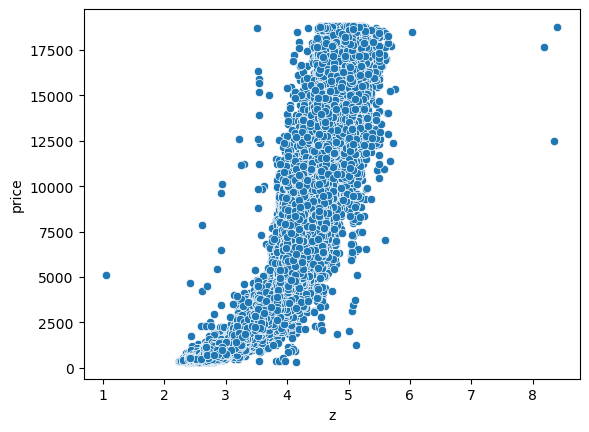

In [76]:
sns.scatterplot(data=df_train, x=df_train.columns[8], y='price')

In [81]:
X, y = df_train.iloc[:,:-1], df_train['price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
model.fit(X_train, y_train)
score = mean_squared_error(y_val, model.predict(X_val))
print(score)

369186.4730450102


# 새로운 feature 생성

In [93]:
df_train['volumn'] = df_train['x']*df_train['y']*df_train['z']
df_test['volumn'] = df_test['x']*df_test['y']*df_test['z']

In [97]:
X, y = df_train.iloc[:,:-1], df_train['price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
model.fit(X_train, y_train)
score = mean_squared_error(y_val, model.predict(X_val), squared=False)
print(score)

0.005352804342064104


# 모델링

In [95]:
y_pred = model.predict(df_test)
df_subm.price = y_pred
df_subm.to_csv('sub.csv', index=False)

In [96]:
model = LGBMRegressor(max_depth=7)
model.fit(X, y)
y_pred = model.predict(df_test)
df_subm.price = y_pred
df_subm.to_csv('sub2.csv', index=False)